## Overview 

Notebook to compute summary statistics of error rates across the crosses.

In [1]:
methods_text = """
We used 11 laboratory crosses to estimate the error associated with genotyping from short reads. 
%
We defined errors at sites where given confident parental genotypes and mendelian inheritance, the expected genotypes of progeny are known. 
%
At loci where both parents are homozygous for the reference or alternate allele, we expect the progeny to be homozygous for the reference or alternate allele accordingly.
%
When one parent is homozygous for the reference allele, and the other the alternate allele we expect all progeny to be heterozygous. 
%
Therefore we can generate ascertainment error estimates for heterozygous, homozygous reference and homozygous alternate genotypes.
%
To meet the confidence threshold for homozygous calls, both parents must have 30x coverage, and have no discordant reads.
%
%
Sites are considered erroneously called if at least 10 progeny have genotypes called at that locus, and one or more do not match the expected genotype. 
%
Sites are considered correctly called if at least 10 progeny have genotypes called and all match the expected genotype. 
%
Crosses had between 14-20 progeny, except cross 61-3 (n=8) which was excluded from this analysis.
%
%
Error in ascertainment rates are computed over each cross, and errors are reported as the median over all 11 crosses. 
%
%
Raw error rates were {raw_het_median:.2f} ({raw_het_min:.2f}, {raw_het_max:.2f}) for heterozygotes, {raw_homr_median:.2f} ({raw_homr_min:.2f}, {raw_homr_max:.2f}) for homozygous reference calls, and {raw_homa_median:.2f} ({raw_homa_min:.2f}, {raw_homa_max:.2f}) for homozygous alternate calls. 
Following variant filtering via QC thresholds and the accessibility map these values dropped to {pass_het_median:.2f} ({pass_het_min:.2f}, {pass_het_max:.2f}) for heterozygotes, {pass_homr_median:.2f} ({pass_homr_min:.2f}, {pass_homr_max:.2f}) for homozygous reference calls, and {pass_homa_median:.2f} ({pass_homa_min:.2f}, {pass_homa_max:.2f}) for homozygous alternate calls. 
"""

We have 11 crosses, we define an error as a site where we expect to see a specific genotype in _all_ progeny. ie 
- Het given parents 00 11
- HomRef given parents 00 00
- HomAlt given parents 11 11

To meet criteria 
(and ). 

In [2]:
import pandas as pd
import zarr
import h5py
import os

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
chrom = '2L'

In [5]:
release_dir = "/kwiat/vector/ag1000g/release/phase2.AR1"

In [6]:
callset_path = os.path.join(
    release_dir, "variation/crosses/hdf5/ag1000g.crosses.phase2.ar1sites.{chrom}.h5")

In [7]:
x_callset = h5py.File(
    callset_path.format(chrom=chrom), mode="r")

In [8]:
xdf = pd.read_table(
    os.path.join(release_dir, "samples", "cross.samples.meta.txt"),
    index_col=0)

In [9]:
# take sample names from the hdf5 file
sample_list = x_callset[chrom]["samples"][:].astype("U8").tolist()

# Drop samples that were not included in sequencing.
xdf = xdf.set_index("ox_code").reindex(sample_list).reset_index()

In [10]:
xdf = xdf.loc[xdf.cross.notna()]
xids = xdf.cross.unique()

In [11]:
xids

array(['18-5', '29-2', '36-9', '73-2', '42-4', '45-1', '46-9', '47-6',
       '78-2', '80-2'], dtype=object)

In [12]:
xdf.groupby(["cross", "role"]).ox_code.count()

cross  role   
18-5   parent      2
       progeny    20
29-2   parent      2
       progeny    20
36-9   parent      2
       progeny    20
42-4   parent      2
       progeny    14
45-1   parent      2
       progeny    20
46-9   parent      2
       progeny    20
47-6   parent      2
       progeny    20
73-2   parent      2
       progeny    19
78-2   parent      2
       progeny    19
80-2   parent      2
       progeny    20
Name: ox_code, dtype: int64

In [13]:
autosomes = ["2L", "2R", "3L", "3R"]
autosomes

['2L', '2R', '3L', '3R']

In [14]:
autosome_acc = {c: pd.read_csv(
    "genotype_call_acc_{chrom}.csv".format(chrom=c), 
    index_col=0, 
    header=[0, 1, 2]) for c in autosomes}

df_all_chrom = pd.concat(autosome_acc)

In [15]:
df_all_chrom

ALL                                             PASS           \
          HOMREF              HET          HOMALT          HOMREF            
         SUCCESS        N SUCCESS       N SUCCESS      N  SUCCESS        N   
2L 18-5   321808   322492    2124    2199     974    982   172793   172947   
   29-2   282738   283493     935     969     999   1008   149373   149536   
   36-9  6386165  6390151   30597   30945   31582  31779  5204406  5205271   
   73-2   320183   320446     519     523     891    893   182586   182590   
   42-4  6572450  6573919  153759  154723   38082  38646  5152248  5152524   
   45-1   266529   266797     789     795     843    847   119913   119926   
   46-9  2622132  2623961   17750   17951   20432  20527  2111704  2112153   
   47-6  1005060  1005743    7180    7222    4952   5038   707566   707780   
   78-2   607891   608230    3080    3098    2364   2373   398547   398571   
   80-2   182100   182358     357     366     542    545    68009    68026   
2R 18-5   408361   409094    2460    2494    1775   1791   242436   242638   
   29-2   438786   439733    4492    4577    2171   2207   268156   268484   
   36-9  9677811  9683315   64438   64982   62114  62571  7964369  7965629   
   73-2   503618   503927    2014    2019    2226   2235   328078   328092   
   42-4  8713384  8715617  162994  163697   72886  73836  7046050  7046425   
   45-1   332159   332420    2052    2064    1538   1543   177008   177029   
   46-9  4046436  4048870   58955   59255   39170  39579  3315779  3316429   
   47-6  1637927  1638823   18369   18439   12280  12493  1222338  1222677   
   78-2   933744   934115    8031    8050    5535   5582   682162   682205   
   80-2   286308   286631     804     809    1233   1238   126870   126911   
3L 18-5   318527   319196    2355    2438    1379   1387   177243   177424   
   29-2   300776   301505    2358    2408    1309   1329   173661   173881   
   36-9  6810554  6814479   37054   37435   37289  37570  5509106  5509969   
   73-2   353966   354246    1269    1275    1261   1271   208206   208222   
   42-4  6347006  6348783   66878   67427   37002  37298  5005493  5005737   
   45-1   289395   289616    1965    1991    1216   1227   146454   146468   
   46-9  2864197  2866127   21038   21210   21067  21199  2295213  2295713   
   47-6  1168608  1169144   10850   10898    6361   6436   835062   835184   
   78-2   687690   688005    6251    6310    3296   3312   472204   472240   
   80-2   215440   215665     565     567     836    846    83891    83907   
3R 18-5   432187   433045    2591    2637    1909   1928   229976   230182   
   29-2   425659   426806    2904    2987    2009   2038   226945   227218   
   36-9  9072016  9077749   71978   72656   65529  66182  7332287  7333487   
   73-2   449383   449763    1571    1578    2109   2112   264643   264661   
   42-4  8400297  8402646  107191  107792   62931  63577  6606789  6607130   
   45-1   401786   402010    1967    1981    1859   1869   181635   181657   
   46-9  3886036  3888931   36580   36830   30295  30570  3091733  3092384   
   47-6  1576657  1577560   16850   16900   10066  10193  1099515  1099777   
   78-2   949247   949603    7687    7736    5481   5534   620795   620827   
   80-2   282573   282891     925     929    1225   1239   112288   112326   

                                        
            HET          HOMALT         
        SUCCESS       N SUCCESS      N  
2L 18-5    1582    1602     725    732  
   29-2     707     718     764    770  
   36-9   24848   24974   26474  26606  
   73-2     378     380     716    718  
   42-4  114328  114608   31019  31460  
   45-1     622     624     582    585  
   46-9   14324   14399   17391  17462  
   47-6    5917    5935    3998   4069  
   78-2    2585    2590    1908   1916  
   80-2     283     283     335    336  
2R 18-5    2036    2049    1390   1404  
   29-2    3718    3762    1670   1696  
   36-9   53425   53654   53016  53374  
  

In [16]:
df  = df_all_chrom.groupby(level=1).agg(sum)
df.columns.names = ["FILTERING", "CLASS", "STATE"]
df.index.name = "CROSS"

In [17]:
df_rates = df.xs(key="SUCCESS", axis=1, level=2) / df.xs(key="N", axis=1, level=2)
df_rates = (1 - df_rates) * 100
df_rates

FILTERING       ALL                          PASS                    
CLASS        HOMREF       HET    HOMALT    HOMREF       HET    HOMALT
CROSS                                                                
18-5       0.198406  2.436527  0.837714  0.090259  1.007824  0.831874
29-2       0.246497  2.303263  1.428137  0.120129  1.231584  1.328502
36-9       0.059902  0.947005  0.801607  0.016099  0.438301  0.710264
42-4       0.026058  0.570660  1.151122  0.005191  0.201018  1.094217
45-1       0.075455  0.849070  0.546847  0.011199  0.265353  0.552923
46-9       0.067680  0.682460  0.814302  0.020801  0.415676  0.764304
47-6       0.055979  0.392824  1.466628  0.024241  0.249089  1.509625
73-2       0.075658  0.407785  0.368607  0.005287  0.153982  0.313112
78-2       0.043428  0.575534  0.744003  0.006210  0.223204  0.768555
80-2       0.116170  0.748783  0.827301  0.028632  0.232992  0.823723

In [18]:
df_rates_melt = df_rates.reset_index().melt(id_vars=['CROSS'])
df_rates_melt.head()

,CROSS,FILTERING,CLASS,value
0,18-5,ALL,HOMREF,0.198406
1,29-2,ALL,HOMREF,0.246497
2,36-9,ALL,HOMREF,0.059902
3,42-4,ALL,HOMREF,0.026058
4,45-1,ALL,HOMREF,0.075455


In [19]:
median_rates = df_rates_melt.groupby(["FILTERING", "CLASS"]).value.agg(np.median)
median_rates

FILTERING  CLASS 
ALL        HET       0.715622
           HOMALT    0.820801
           HOMREF    0.071567
PASS       HET       0.257221
           HOMALT    0.796139
           HOMREF    0.018450
Name: value, dtype: float64

In [20]:
mean_rates = df_rates_melt.groupby(["FILTERING", "CLASS"]).value.agg(np.mean)
mean_rates

FILTERING  CLASS 
ALL        HET       0.991391
           HOMALT    0.898627
           HOMREF    0.096523
PASS       HET       0.441902
           HOMALT    0.869710
           HOMREF    0.032805
Name: value, dtype: float64

In [21]:
min_rates = df_rates_melt.groupby(["FILTERING", "CLASS"]).value.agg(np.min)
min_rates

FILTERING  CLASS 
ALL        HET       0.392824
           HOMALT    0.368607
           HOMREF    0.026058
PASS       HET       0.153982
           HOMALT    0.313112
           HOMREF    0.005191
Name: value, dtype: float64

In [22]:
max_rates = df_rates_melt.groupby(["FILTERING", "CLASS"]).value.agg(np.max)
max_rates

FILTERING  CLASS 
ALL        HET       2.436527
           HOMALT    1.466628
           HOMREF    0.246497
PASS       HET       1.231584
           HOMALT    1.509625
           HOMREF    0.120129
Name: value, dtype: float64

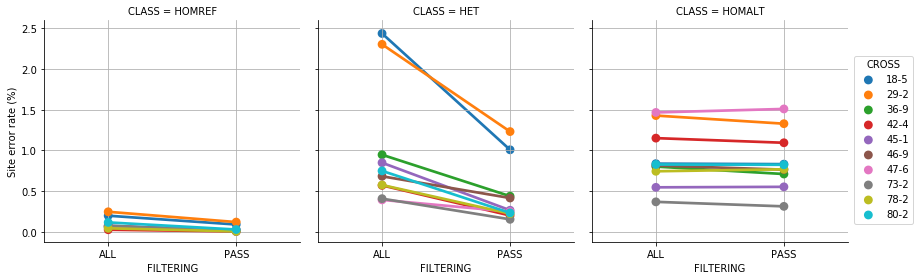

In [23]:
axes = sns.factorplot(
    col="CLASS", 
    y="value", 
    x="FILTERING", 
    hue="CROSS", 
    data=df_rates_melt, 
    kind="point", 
    sharey=True)

axes.set_ylabels("Site error rate (%)")
for row in axes.axes:
    for r in row:
        r.grid(True)
        
axes.savefig("snp_validation_ascertainment.jpeg", bbox_inches="tight", dpi=100)

In [24]:
with open("snp_validation_methods.tex", mode="w") as write:
    print(methods_text.format(
        raw_het_median=median_rates.loc["ALL", "HET"],
        raw_het_min=min_rates.loc["ALL", "HET"],
        raw_het_max=max_rates.loc["ALL", "HET"],
        raw_homr_median=median_rates.loc["ALL", "HOMREF"],
        raw_homr_min=min_rates.loc["ALL", "HOMREF"],
        raw_homr_max=max_rates.loc["ALL", "HOMREF"],
        raw_homa_median=median_rates.loc["ALL", "HOMALT"],
        raw_homa_min=min_rates.loc["ALL", "HOMALT"],
        raw_homa_max=max_rates.loc["ALL", "HOMALT"],
        pass_het_median=median_rates.loc["PASS", "HET"],
        pass_het_min=min_rates.loc["PASS", "HET"],
        pass_het_max=max_rates.loc["PASS", "HET"],
        pass_homr_median=median_rates.loc["PASS", "HOMREF"],
        pass_homr_min=min_rates.loc["PASS", "HOMREF"],
        pass_homr_max=max_rates.loc["PASS", "HOMREF"],
        pass_homa_median=median_rates.loc["PASS", "HOMALT"],
        pass_homa_min=min_rates.loc["PASS", "HOMALT"],
        pass_homa_max=max_rates.loc["PASS", "HOMALT"]), file=write)